In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import keras

In [34]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [36]:
tf.test.is_gpu_available()

True

In [37]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1. 데이터 불러오기

* 데이터는 한 시간 간격으로 기록
* 기상 데이터 - 2015-01-01 ~ 2021-04-30 당진 기상관측데이터, 울산 기상관측데이터
* 발전량 데이터 - 2015-01-01 ~ 2021-01-31 수상, 자재창고, 당진, 울산 4개 장소
                                          (ulsan_not_used 열은 삭제하고 진행)

In [38]:
#당진, 울산 기상 관측 데이터
raw_weather_dangjin = pd.read_csv('Solar_Power_mycode/proc_by_yj15-21/dangjin_obs_15_21.csv')
raw_weather_ulsan = pd.read_csv('Solar_Power_mycode/proc_by_yj15-21/ulsan_obs_15_21.csv')

# floating, warehouse, dangjin, ulsan 발전량 데이터
raw_power_dataset = pd.read_csv('Solar_Power_mycode/proc_by_yj15-21/energy_new.csv') 

#### 1.1 기상데이터

In [39]:
for i in range(raw_weather_dangjin['Cloud'].shape[0]):
    if raw_weather_dangjin['Cloud'][i] not in [1,2,3,4]:
        raw_weather_dangjin['Cloud'][i] = raw_weather_dangjin['Cloud'][i-1]

<ipython-input-39-4ab4b50d1efa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_weather_dangjin['Cloud'][i] = raw_weather_dangjin['Cloud'][i-1]


In [40]:
np.where(raw_weather_dangjin['Cloud'].isin([1,2,3,4]))[0].shape

(55488,)

In [41]:
print(raw_weather_dangjin.shape, raw_weather_ulsan.shape)
raw_weather_dangjin.tail()

(55488, 8) (55488, 8)


,Time,ghi,GHI,Temperature,Humidity,Wind_x,Wind_y,Cloud
55483,2021-04-30 19:00,0.11,30.555558,10.1,84.0,-2.300000e+00,-5.630000e-16,4.0
55484,2021-04-30 20:00,0.00,0.000000,9.7,82.0,-1.221600e+00,4.446262e-01,4.0
55485,2021-04-30 21:00,NaN,0.000000,9.3,86.0,-3.078181e-01,-8.457234e-01,4.0
55486,2021-04-30 22:00,NaN,0.000000,9.1,90.0,6.120000e-18,1.000000e-01,4.0
55487,2021-04-30 23:00,NaN,0.000000,8.8,93.0,-3.213938e-01,3.830222e-01,4.0


* cos(time) 변수 추가 및 null값이 있는 ghi 열 삭제

In [42]:
cos_time = []
for i in range(raw_weather_dangjin['Time'].shape[0]):
     cos_time.append(np.cos(2*np.pi/24*int(raw_weather_dangjin['Time'][i][-5:-3])))
cos_weather_dangjin = pd.concat([raw_weather_dangjin,pd.DataFrame(cos_time)],axis=1)
cos_weather_ulsan = pd.concat([raw_weather_ulsan,pd.DataFrame(cos_time)],axis=1)
cos_weather_dangjin.rename(columns = {0:'cos(time)'}, inplace=True)
cos_weather_ulsan.rename(columns = {0:'cos(time)'}, inplace=True)

In [43]:
cos_weather_dangjin.head()

,Time,ghi,GHI,Temperature,Humidity,Wind_x,Wind_y,Cloud,cos(time)
0,2015-01-01 0:00,NaN,0.0,NaN,NaN,-1.812707,4.980371,3.0,1.000000
1,2015-01-01 1:00,NaN,0.0,-4.4,47.0,-1.846909,5.074340,3.0,0.965926
2,2015-01-01 2:00,NaN,0.0,-4.6,50.0,-1.675899,4.604494,3.0,0.866025
3,2015-01-01 3:00,NaN,0.0,-4.7,50.0,-3.985283,4.749476,3.0,0.707107
4,2015-01-01 4:00,NaN,0.0,-5.0,56.0,-3.213938,3.830222,3.0,0.500000


In [44]:
cos_weather_ulsan.head()

,Time,ghi,GHI,Temperature,Humidity,Wind_x,Wind_y,Cloud,cos(time)
0,2015-01-01 0:00,NaN,0.0,NaN,NaN,-6.108002,2.223131e+00,1,1.000000
1,2015-01-01 1:00,NaN,0.0,-1.0,42.0,-4.500000,-1.100000e-15,1,0.965926
2,2015-01-01 2:00,NaN,0.0,-1.3,39.0,-2.185478,2.604551e+00,1,0.866025
3,2015-01-01 3:00,NaN,0.0,-2.5,49.0,-3.213938,3.830222e+00,1,0.707107
4,2015-01-01 4:00,NaN,0.0,-3.3,36.0,-5.826094,2.120525e+00,1,0.500000


In [45]:
weather_dangjin = cos_weather_dangjin[[
                             'cos(time)',
                             'GHI',
                             'Temperature',
                             'Humidity',
                             'Wind_x',
                             'Wind_y']]
weather_ulsan = cos_weather_ulsan[[
                             'cos(time)',
                             'GHI',
                             'Temperature',
                             'Humidity',
                             'Wind_x',
                             'Wind_y']]

#### 1.2 발전량 데이터

In [46]:
power_dataset = raw_power_dataset[:]
power_dataset.head()

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan_not_used,ulsan
0,2015-01-01 1:00,0.0,0.0,0.0,NaN,NaN
1,2015-01-01 2:00,0.0,0.0,0.0,NaN,NaN
2,2015-01-01 3:00,0.0,0.0,0.0,NaN,NaN
3,2015-01-01 4:00,0.0,0.0,0.0,NaN,NaN
4,2015-01-01 5:00,0.0,0.0,0.0,NaN,NaN


* 데이터 분포 시각화
* null 값이 드문드문 보임
* 당진, 울산 일사량 분포 이상 -> 당진은 구간을 나눠 MinMax 진행, 울산은 별다른 조치 x

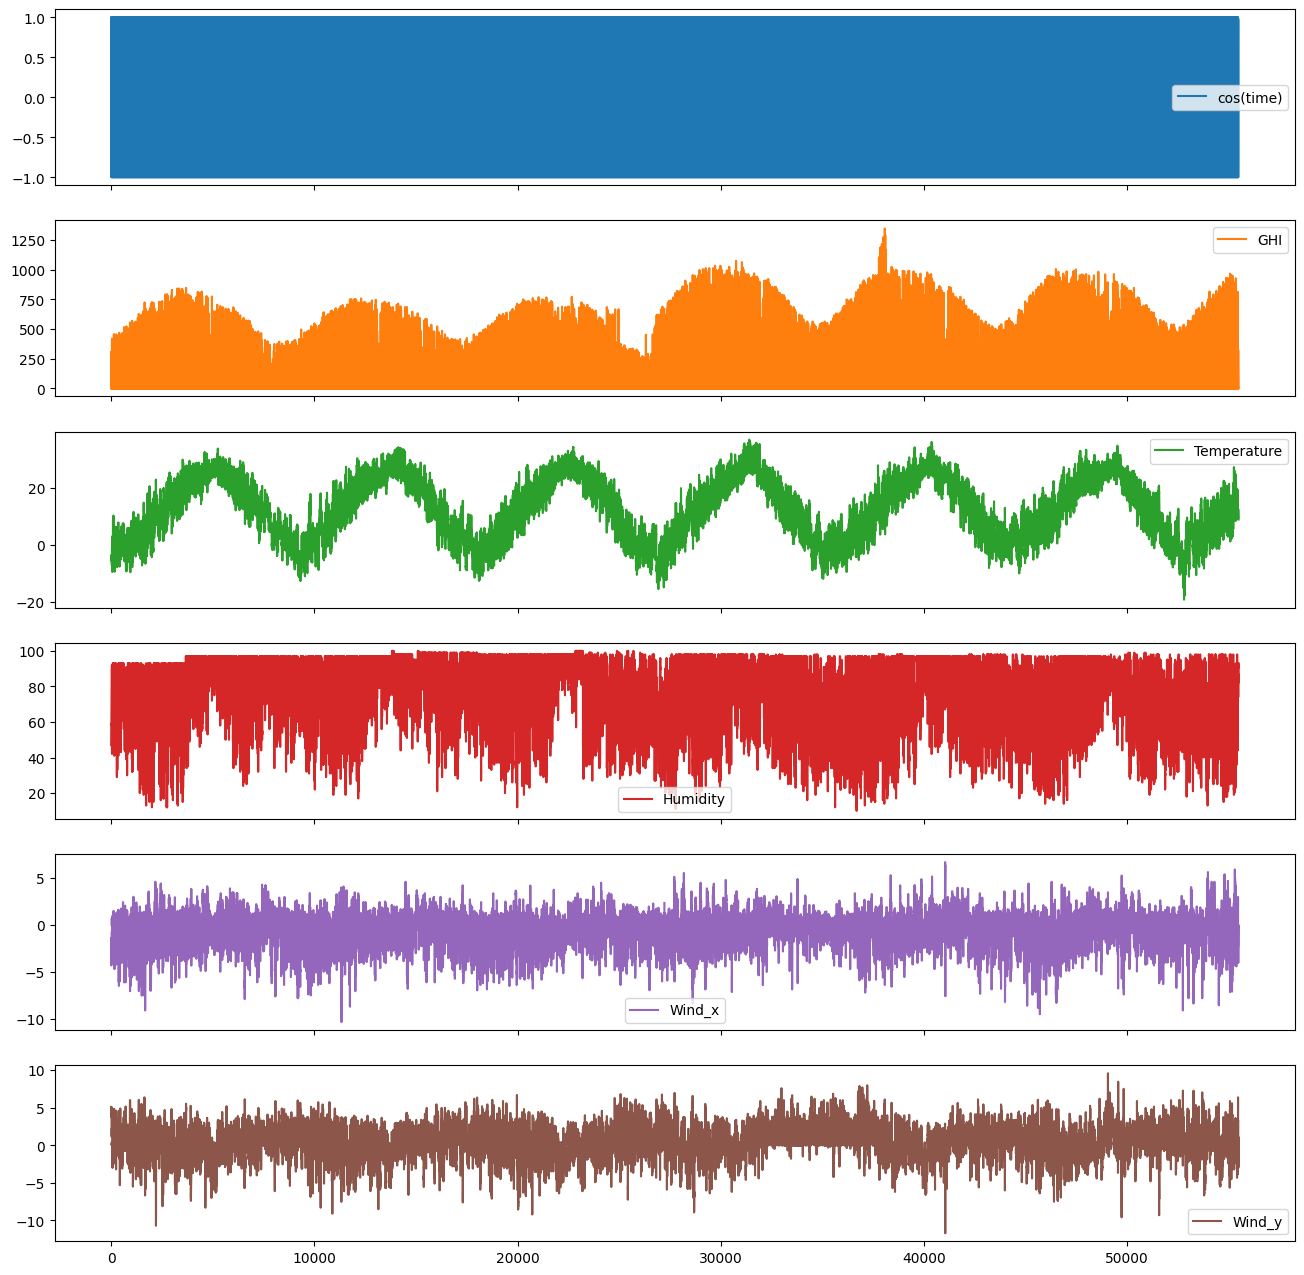

In [17]:
plt.style.use("default")
weather_dangjin.plot(subplots=True, figsize=(16, 16));

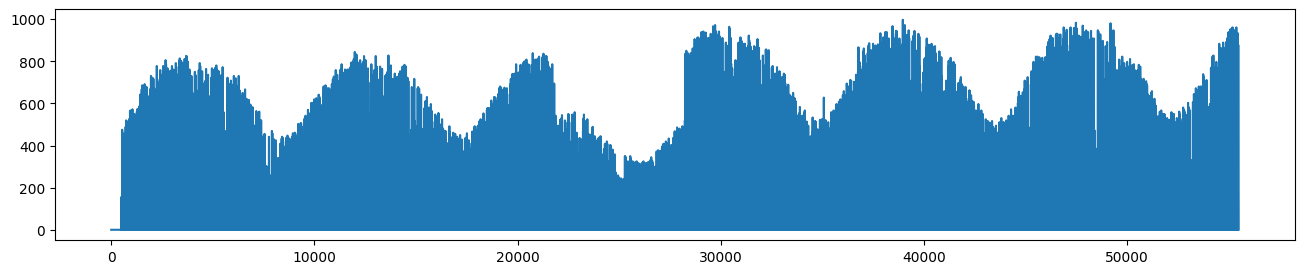

In [18]:
weather_ulsan['GHI'].plot(figsize=(16,3));

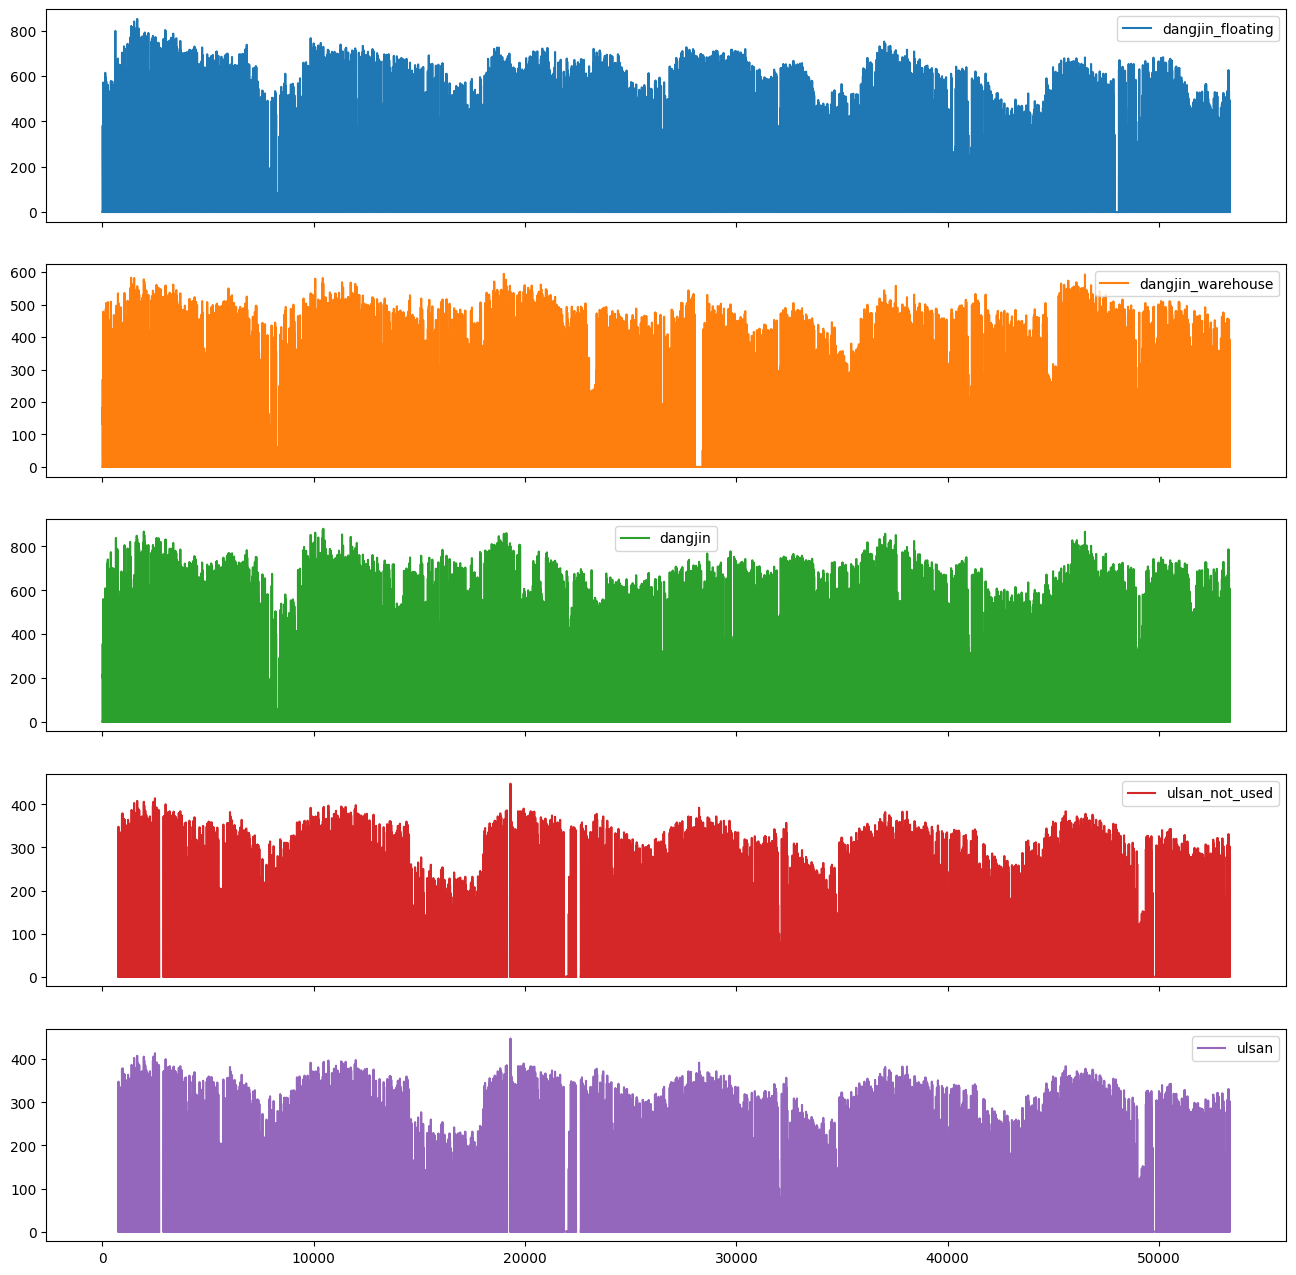

In [19]:
power_dataset.plot(subplots=True, figsize=(16,16));

* 이상치 제거 및 결측치 채워넣기

In [20]:
#1000이상인 일사량을 이상치로 보고 null로 대체
for i in range(len(weather_dangjin)):
    if weather_dangjin['GHI'][i] > 1000:
        weather_dangjin['GHI'][i] = np.nan;

C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py:3427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
power_dataset = power_dataset.drop(['ulsan_not_used','time'], axis=1)

In [22]:
# null 값들을 K-Nearest Neighbor로 값을 채워줌
from sklearn.impute import KNNImputer
from numpy import isnan

imputer = KNNImputer()
imputer.fit(weather_dangjin.values)
imp_weather_dangjin = imputer.transform(weather_dangjin.values)

imputer.fit(weather_ulsan.values)
imp_weather_ulsan = imputer.transform(weather_ulsan.values)

imputer.fit(power_dataset.values)
proc_power_dataset = imputer.transform(power_dataset.values)

print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(imp_weather_dangjin).flatten()))
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(imp_weather_ulsan).flatten()))
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(proc_power_dataset).flatten()))

데이터 내에 존재하는 NaN의 갯수: 0
데이터 내에 존재하는 NaN의 갯수: 0
데이터 내에 존재하는 NaN의 갯수: 0


In [23]:
bound_for_scaler = np.where(raw_weather_dangjin['Time']=='2018-01-01 0:00')[0][0]

In [24]:
imp_weather_dangjin_1 = imp_weather_dangjin[bound_for_scaler:]
imp_weather_dangjin_2 = imp_weather_dangjin[:bound_for_scaler]

In [25]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import scipy as sp
import scipy.stats
scaler = MinMaxScaler()
scaler.fit(imp_weather_dangjin_1)
imp_weather_dangjin_1_scaled = scaler.transform(imp_weather_dangjin_1)
# 당진만 2개로 쪼개서 각각 스케일링
scaler.fit(imp_weather_dangjin_2)
imp_weather_dangjin_2_scaled = scaler.transform(imp_weather_dangjin_2)

scaler.fit(imp_weather_ulsan)
imp_weather_ulsan_scaled = scaler.transform(imp_weather_ulsan)

imp_weather_dangjin_scaled = pd.concat([pd.DataFrame(imp_weather_dangjin_2_scaled),
                                        pd.DataFrame(imp_weather_dangjin_1_scaled)], axis =0)

proc_weather_dangjin = pd.DataFrame(data = np.array(imp_weather_dangjin_scaled),
                                 columns=['cos(time)',
                                         'GHI',
                                         'Temperature',
                                         'Humidity',
                                         'Wind_x',
                                         'Wind_y'])
proc_weather_ulsan = pd.DataFrame(data=imp_weather_ulsan_scaled, 
                                 columns=['cos(time)',
                                         'GHI',
                                         'Temperature',
                                         'Humidity',
                                         'Wind_x',
                                         'Wind_y'])


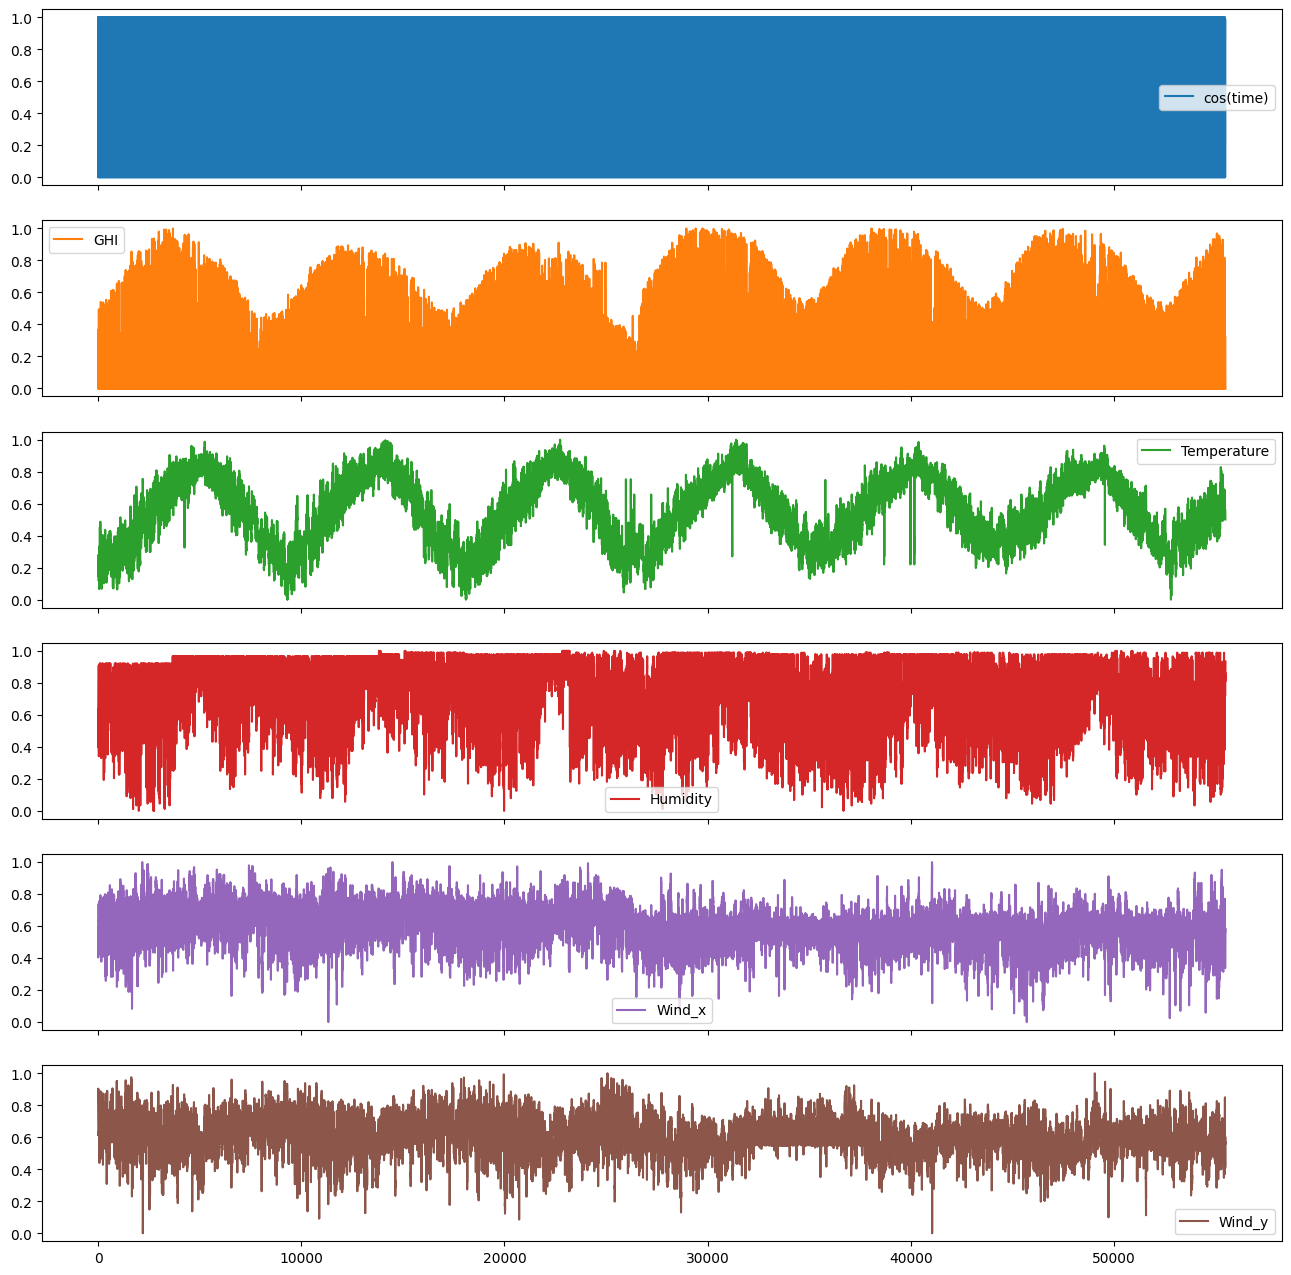

In [26]:
plt.style.use("default")
proc_weather_dangjin.plot(subplots=True, figsize=(16,16));

In [27]:
proc_power_dataset = pd.DataFrame(power_dataset)
proc_power_dataset

,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,NaN
...,...,...,...,...
53347,0.0,0.0,0.0,0.0
53348,0.0,0.0,0.0,0.0
53349,0.0,0.0,0.0,0.0
53350,0.0,0.0,0.0,0.0


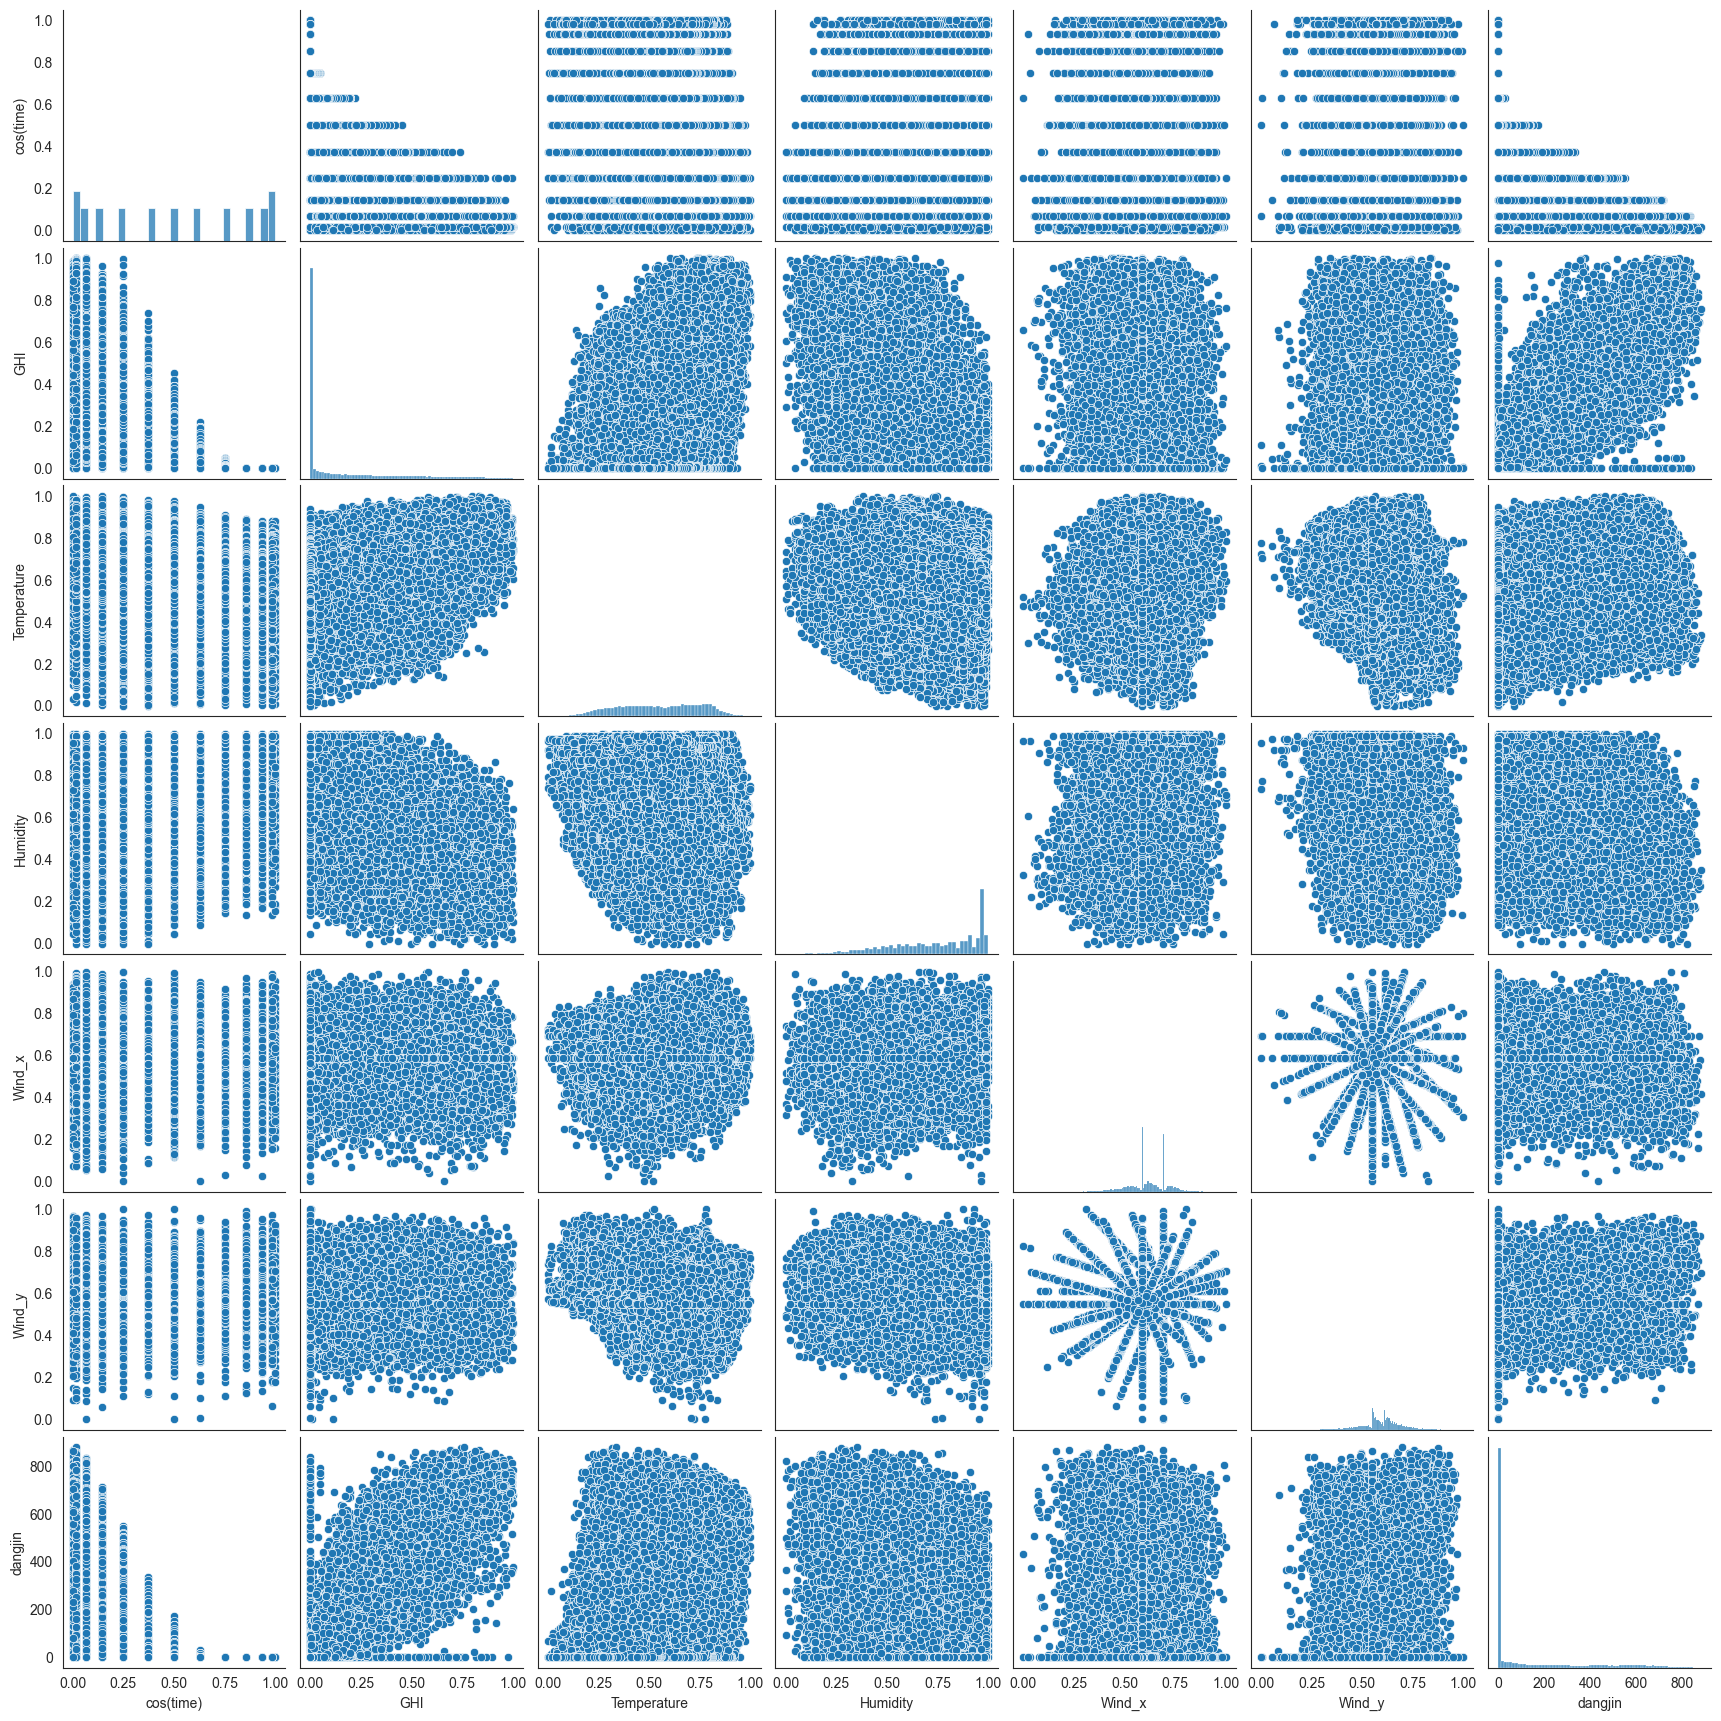

In [28]:
import seaborn as sns
sns.set_style("white")
sns.pairplot(pd.concat([proc_weather_dangjin[['cos(time)',
                                         'GHI',
                                         'Temperature',
                                         'Humidity',
                                         'Wind_x',
                                         'Wind_y']], pd.DataFrame(proc_power_dataset)['dangjin']],
                                          axis=1))


In [29]:
temp_dataset_dangjin = pd.concat([proc_weather_dangjin,
                             raw_weather_dangjin['Cloud'],
                             proc_power_dataset.drop('ulsan', axis=1)],axis=1)
temp_dataset_ulsan = pd.concat([proc_weather_ulsan,
                             raw_weather_dangjin['Cloud'],
                             proc_power_dataset['ulsan']],axis=1)

imputer.fit(temp_dataset_dangjin.values)
final_dataset_dangjin = imputer.transform(temp_dataset_dangjin.values)

imputer.fit(temp_dataset_ulsan.values)
final_dataset_ulsan = imputer.transform(temp_dataset_ulsan.values)

In [30]:
final_dataset_dangjin = pd.DataFrame(final_dataset_dangjin, columns = temp_dataset_dangjin.columns)
final_dataset_ulsan = pd.DataFrame(final_dataset_ulsan, columns = temp_dataset_ulsan.columns)

In [32]:
final_dataset_dangjin.to_csv('Solar_Power_mycode/data/final_dataset_dangjin.csv', index=False)
final_dataset_ulsan.to_csv('Solar_Power_mycode/data/final_dataset_ulsan.csv', index=False)